<h2>  Part Two: Exploratory data analysis and feature extraction. </h2>	


<h5> In this section, Compute at least 15 such image features (a method for each), including the following (NOTE: At least 10 of these must be scalar features and 2 matrix-based features): (i) image size, (ii) average of the red-channel intensity, (iii) aspectratio. This will require significant explatoratory research and data analysis. The first one is already implemented for you, and the next two are pre-specified. Additional requirements specfied in pdf. </h5>

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import skimage
from skimage import data
from skimage import io
from skimage import color
from skimage import feature
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
from skimage.feature import corner_harris, corner_peaks
from skimage.feature import greycomatrix, greycoprops
import seaborn as sns

## Helper functions or functions used in EDA

In [4]:
def class_frequency(data):
    total_population = len(training_raw.index)
    class_population = data.groupby('Encoding')['Pictures'].count().tolist()
    return np.true_divide(class_population, total_population)

def image_shape(im):
    return im.shape
            
def shape_size(im):
    return len(image_shape(im))

def is_gray_scale(im):
    if shape_size(im) == 2:
        return True
    else:
        return False
def image_height(im):
    sh=image_shape(im)
    return sh[0]
def image_width(im):
    sh=image_shape(im)
    return sh[1]
# color space conversion
def to_rgb(im):
    if is_gray_scale(im):
        im = color.gray2rgb(im)
    return im

def to_hsv(im):
    if is_gray_scale(im):
        im = color.gray2rgb(im)
    return color.rgb2hsv(im)

def to_gray(im):
    if ~is_gray_scale(im):
        im = color.rgb2gray(im)
    return im

## Feature functions

In [5]:
def image_size(im):
    # return image size
    return im.size


    
def average_red(im):
    # return average intensity in red channel
    if is_gray_scale(im):
        im = color.gray2rgb(im)
    return im[:, :, 0].mean()

def average_green(im):
    # return average intensity in green channel
    if is_gray_scale(im):
        im = color.gray2rgb(im)
    return im[:, :, 1].mean()

def average_blue(im):
    # return average intensity in blue channel
    if is_gray_scale(im):
        im = color.gray2rgb(im)
    return im[:, :, 2].mean()

def aspect_ratio(im):
    return np.true_divide(im.shape[0],im.shape[1])



def average_hue(im):
    if is_gray_scale(im):
        im = color.gray2rgb(im)
    im = color.rgb2hsv(im)
    return im[:,:,0].mean()

def average_saturation(im):
    if is_gray_scale(im):
        im = color.gray2rgb(im)
    im = color.rgb2hsv(im)
    return im[:,:,1].mean()

def average_value(im):
    if is_gray_scale(im):
        im = color.gray2rgb(im)
    im = color.rgb2hsv(im)
    return im[:,:,2].mean()

def image_resize(im):
    return resize(im,(340, 403), anti_aliasing=True)

def vec_to_scalar_features(im_list):
    feature_matrix = np.zeros((len(im_list), 340*403*3))
    count = 0
    for array in im_list:
        
        feature_matrix[count]=np.array(array).flatten()
        count+=1
    return feature_matrix

def pca_features(training_raw, n_components):
    # return top n_components pca features as a dataframe
    training_raw['image_resize'] = training_raw['Pictures'].apply(image_resize)
    feature_matrix = vec_to_scalar_features(training_raw['image_resize'].apply(to_rgb).tolist())
    feature_matrix=StandardScaler().fit_transform(feature_matrix)
    pca = PCA(n_components=n_components)
    pca.fit(feature_matrix)
    pca_feature_matrix=pca.transform(feature_matrix)
    columns = ['pca'+str(i) for i in np.arange(n_components)+1]
    pca_df=pd.DataFrame(data=pca_feature_matrix, columns=columns)
    return pca_df

def to_harris_corner(im):
    im = to_gray(im)
    return corner_harris(im)
    
def harris_corner_number(im):
    im = to_harris_corner(im)
    coords = corner_peaks(im, min_distance=1)
    return len(coords)
            
def float_gray_to_uint8(im):
    im = 255*np.true_divide(im, im.max())
    return im.astype(np.uint8)
        
def glcm_based_featrues(im):
    im= to_gray(im)
    im = image_resize(im)    
    im = float_gray_to_uint8(im)
    
    # compute glcm 
    glcm = greycomatrix(im, [5], [0, np.pi/4, np.pi/2, 3*np.pi/4], 256)
    # compute properties of glcm matrix
    contrast = greycoprops(glcm, 'contrast')[0,0]
    dis = greycoprops(glcm, 'dissimilarity')[0,0]
    homo = greycoprops(glcm, 'homogeneity')[0,0]
    asm = greycoprops(glcm, 'ASM')[0,0]
    energy = greycoprops(glcm, 'energy')[0,0]
    cor = greycoprops(glcm, 'correlation')[0,0]
    return contrast, dis, homo, asm, energy, cor


## Feature dataframe creation

In [6]:
def feature_generaion(df):
    # this returns a matrix contains all the features  and also corresponding encoding
    feature_df = pd.DataFrame()
    feature_df['contrast'], feature_df['dissimilarity'], feature_df['homogeneity'], feature_df['asm'], feature_df['energy'], feature_df['cor'] = zip(*df['Pictures'].apply(glcm_based_featrues))
    feature_df['Encoding'] = df['Encoding']
    feature_df['image_size'] = df['Pictures'].apply(image_size)
    feature_df['average_red'] = df['Pictures'].apply(average_red)
    feature_df['average_green'] = df['Pictures'].apply(average_green)
    feature_df['average_blue'] = df['Pictures'].apply(average_blue)
    feature_df['aspect_ratio'] = df['Pictures'].apply(aspect_ratio)
    feature_df['hue'] = df['Pictures'].apply(average_hue)
    feature_df['saturation'] = df['Pictures'].apply(average_saturation)
    feature_df['value'] = df['Pictures'].apply(average_value)

    pca_df = pca_features(df, 10)
    feature_df = pd.concat([feature_df, pca_df], axis=1)

    feature_df['corner_number'] = df['Pictures'].apply(harris_corner_number)
    return feature_df

Read in raw data

In [7]:
class_labels = ['Airplanes', 'Bear', 'Blimp', 'Comet', 'Crab', 'Dog', 'Dolphin', 'Giraffe', 'Goat', 'Gorilla', 'Kangaroo', 'Killer-Whale', 'Leopards', 'Llama', 'Penguin', 'Porcupine', 'Teddy-Bear', 'Triceratops', 'Unicorn', 'Zebra']
training_raw = pd.read_pickle(os.path.join(os.getcwd(), 'training_data.pkl'))
test_raw = pd.read_pickle(os.path.join(os.getcwd(), 'test_data.pkl'))

Create feature dataframe for both learning set and test set. Also save them

In [8]:
test_feature_df=feature_generaion(test_raw)
feature_df = feature_generaion(training_raw)
test_feature_df.to_pickle(os.path.join(os.getcwd(), 'dummy_test_feature_data.pkl'))
feature_df.to_pickle(os.path.join(os.getcwd(), 'dummy_train_feature_data.pkl'))

 We expect all external sources sited, and significant indication of EDA. 

## Graphs

C:\Users\ZS\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


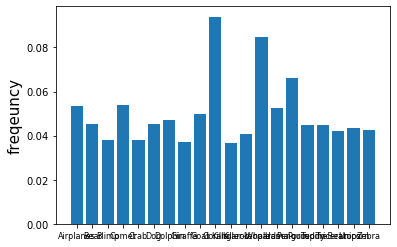

In [9]:
class_freq = class_frequency(training_raw)
# figure 1: class_frequency
fig, ax = plt.subplots()
ax.bar(class_labels, class_freq)
ax.set_ylabel('freqeuncy', fontsize=15)
for tick in ax.get_xticklabels():
    tick.set_fontsize(8)
fig.show()

Text(0.5, 0, 'number of top pca features')

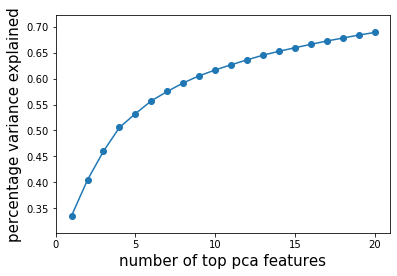

In [10]:
# pca variance contribution
training_raw['image_resize'] = training_raw['Pictures'].apply(image_resize)
feature_matrix = vec_to_scalar_features(training_raw['image_resize'].apply(to_rgb).tolist())
covar_matrix = PCA(n_components=20)
covar_matrix.fit(feature_matrix)
variance = covar_matrix.explained_variance_ratio_

# figure 2: pca components explaination
fig, ax = plt.subplots()
ax.scatter(np.arange(20)+1, np.cumsum(variance))
ax.plot(np.arange(20)+1, np.cumsum(variance))
plt.xticks([0,5,10,15,20], [0,5,10,15,20])
ax.set_ylabel('percentage variance explained', fontsize=15)
ax.set_xlabel('number of top pca features', fontsize=15)

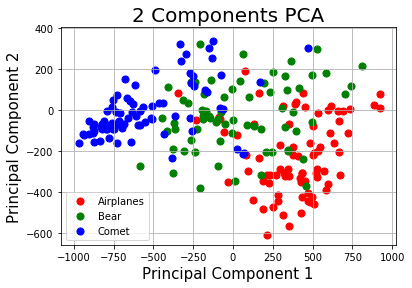

In [11]:
# pca components for different classes
# figure 3: 2 pca components for class seperation
fig, ax = plt.subplots()
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Components PCA', fontsize = 20)
#
#
Encodings = [0, 1, 3]
legends = [class_labels[i] for i in Encodings]
colors = ['r', 'g', 'b']
for encoding, color in zip(Encodings,colors):
    indicesToKeep = feature_df['Encoding'] == encoding
    ax.scatter(feature_df.loc[indicesToKeep, 'pca1']
               , feature_df.loc[indicesToKeep, 'pca2']
               , c = color
               , s = 50)
ax.legend(legends)
ax.grid()

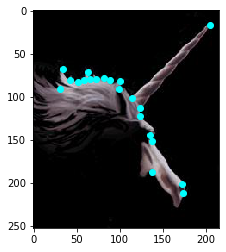

In [23]:
## Haris corner
image=io.imread(os.path.join(os.getcwd(), '20_categories_training', 'unicorn','unicorn_0040.jpg'))
coords = corner_peaks(corner_harris(to_gray(image)), min_distance=5)
# figure 4: haris corner detection picture
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',linestyle='None', markersize=6)
plt.show()

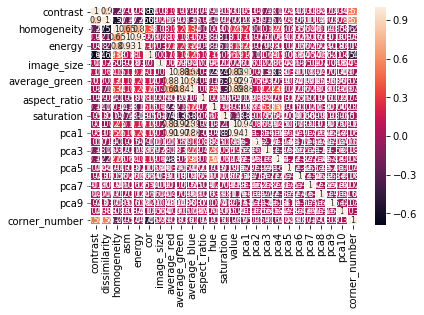

In [21]:
## EDA on feature matrix
## correlation heat map
feature_df = pd.read_pickle(os.path.join(os.getcwd(), 'training_feature_data.pkl'))
label_df = pd.DataFrame()
label_df['Encoding'] = feature_df['Encoding']
feature_df = feature_df.drop(columns=['Encoding'])


# figure 5: correlation heatmap for all features
cov=feature_df.corr()
fig, ax = plt.subplots()         
ax = sns.heatmap(cov, annot=True, annot_kws={'size': 8}, linewidths=.5)

In [24]:
# feature scaling for better plot
scaler = StandardScaler()
scaler.fit(feature_df)
feature_df[list(feature_df.columns)] = scaler.transform(feature_df)

Text(0, 0.5, 'cor')

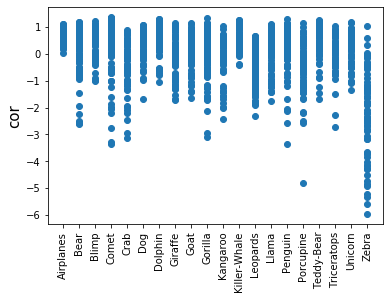

In [25]:
## figure 6: feature-class scattering plot
fig, ax = plt.subplots()
column_name='cor'
ax.scatter(label_df['Encoding'], feature_df[column_name])
plt.xticks(np.arange(20), class_labels, rotation='vertical')
ax.set_ylabel(column_name, fontsize=15)

Text(0.5, 0, '')

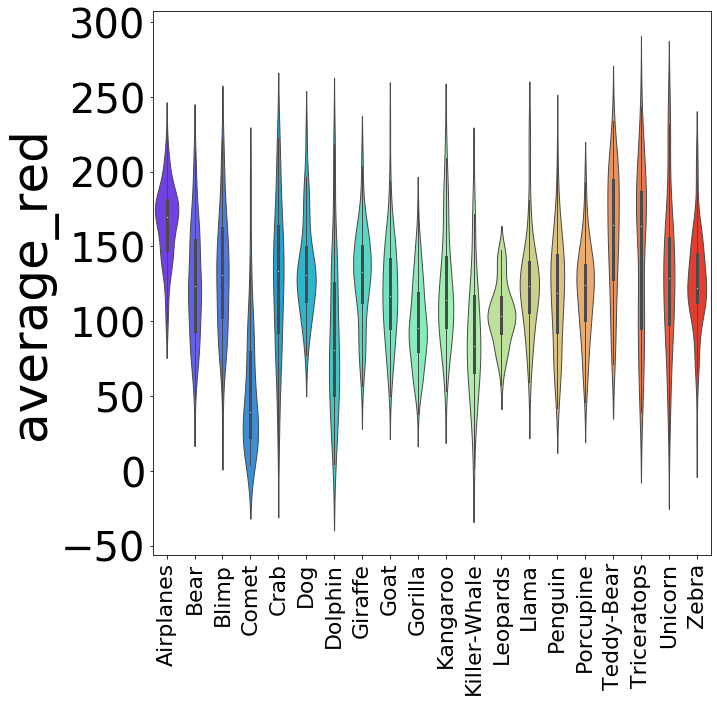

In [26]:
## figure 7: violin graph

column_name='average_red'
## non-scaled feature plot
feature_df = pd.read_pickle(os.path.join(os.getcwd(), 'training_feature_data.pkl'))
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.violinplot(feature_df['Encoding'], feature_df[column_name], palette='rainbow',linewidth=1, width=1)
plt.xticks(np.arange(20), class_labels, rotation='vertical', fontsize=22)
plt.yticks(fontsize=40)
ax.set_ylabel(column_name, fontsize=50)
ax.set_xlabel('')
